In [2]:
from data_processing.Dataset import PixelDataset

ImportError: cannot import name 'PixelDataset' from partially initialized module 'data_processing.Dataset' (most likely due to a circular import) (c:\Users\jurko\OneDrive - Universidad Pontificia Comillas\Documentos\Proyectos\image_generator\src\data_processing\Dataset.py)

In [2]:
from torch.utils.data import DataLoader

In [3]:
dataset = PixelDataset("../dataset/sprites.npy", "../dataset/sprites_labels.npy")
dataloader = DataLoader(dataset, batch_size=156, shuffle=True, num_workers=4)

In [4]:
len(dataset)

89400

In [5]:
for image, label in dataloader:
    print(image[0].shape)
    print(label)
    break

torch.Size([16, 16, 3])
tensor([[0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0.,

In [3]:
from models.autoencoder import Encoder, Decoder
import torch.nn as nn
import torch

In [8]:
encoder = Encoder()
decoder = Decoder()
autoencoder = nn.Sequential(encoder, decoder)


In [9]:
# output = autoencoder(next(iter(dataloader))[0])
# output = torch.stack([image.permute(2,0,1).int() for image in output])
# grid = make_grid(output, nrow=4, padding = 2)
# plt.imshow(grid.permute(1,2,0))
# plt.show()

In [10]:
# subset = torch.utils.data.Subset(dataset, range(32))
# # print(len(dataset))
# dataloader = DataLoader(subset, batch_size=4, shuffle=True, num_workers=0)


In [11]:
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from torch.nn import MSELoss
optimizer = Adam(autoencoder.parameters(), lr=0.01)
scheduler = ExponentialLR(optimizer, gamma=0.9)

In [12]:

def get_gradient_norm(model):
    total_norm = 0.0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    return total_norm

In [13]:
def train_loop(dataloader, model, loss_fn, optimizer, epochs=5) -> tuple[list, list]:
    model.train()
    size = len(dataloader.dataset)
    losses = []
    gradients = []
    try:
        for epoch in range(epochs):
            print(f"Epoch {epoch+1}\n-------------------------------")
            for batch, (X, label) in enumerate(dataloader):
                # Compute prediction error
                pred = model(X)
                loss = loss_fn(pred, X)
                
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()

                torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
                optimizer.step()

                
                gradients.append(get_gradient_norm(model))
                losses.append(loss.item())
                if batch % 32 == 0:
                    loss, current = loss.item(), batch * len(X)
                    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            scheduler.step()
    except KeyboardInterrupt:
        pass

    return losses, gradients

In [14]:
losses, gradients = train_loop(dataloader, autoencoder, MSELoss(), optimizer, epochs=1)

Epoch 1
-------------------------------
loss: 37802.679688  [    0/89400]
loss: 8651.000977  [ 4992/89400]
loss: 8056.723145  [ 9984/89400]
loss: 7265.149414  [14976/89400]
loss: 5942.890137  [19968/89400]
loss: 5459.165527  [24960/89400]
loss: 5163.061035  [29952/89400]
loss: 5105.179688  [34944/89400]
loss: 4623.454102  [39936/89400]
loss: 5083.098145  [44928/89400]
loss: 4812.738770  [49920/89400]
loss: 4644.868652  [54912/89400]
loss: 4345.795410  [59904/89400]
loss: 4608.004883  [64896/89400]
loss: 4515.396973  [69888/89400]
loss: 4599.203125  [74880/89400]
loss: 4146.195312  [79872/89400]
loss: 4580.081543  [84864/89400]


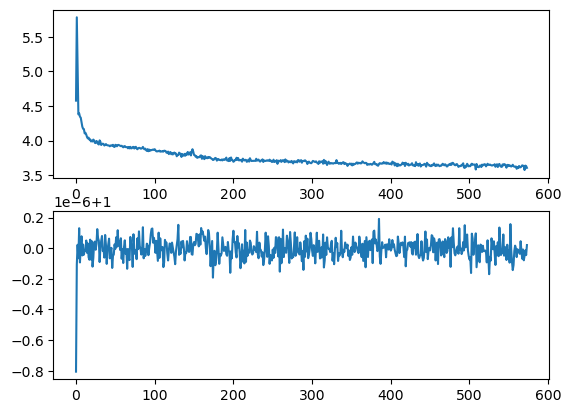

In [15]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2)
axes[0].plot(torch.log10(torch.tensor(losses)))
axes[1].plot(gradients)
plt.show()

torch.Size([3, 16, 16])
torch.Size([8, 3, 16, 16])
torch.Size([3, 38, 74])


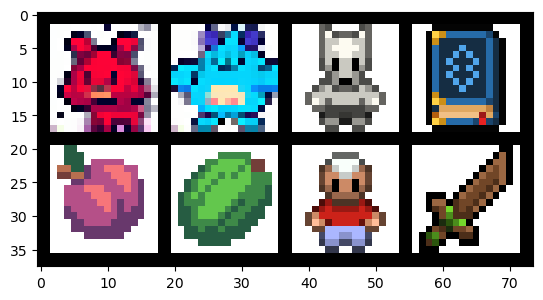

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


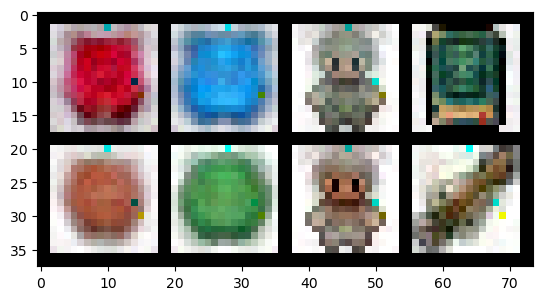

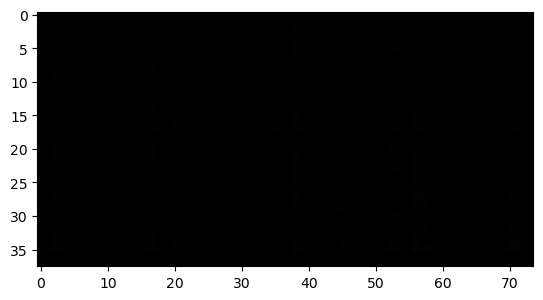

In [16]:
dataset[0][0]
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
images_not, _ = next(iter(dataloader))
images = torch.stack([image.permute(2,0,1).int() for image in images_not[:8]])
print(images[3].int().shape)
print(images.shape)
grid = make_grid(images, nrow=4, padding = 2)
print(grid.shape)
plt.imshow(grid.permute(1,2,0))

plt.show()

autoencoder.eval()
with torch.no_grad():
    output = autoencoder(images_not[:8])
    output = torch.stack([image.permute(2,0,1).int() for image in output])
    grid = make_grid(output, nrow=4, padding = 2)
    plt.imshow(grid.permute(1,2,0))
    plt.show()

with torch.no_grad():
    images_not = torch.randn(8,30)
    output = decoder(images_not[:8])
    output = torch.stack([image.permute(2,0,1).int() for image in output])
    grid = make_grid(output, nrow=4, padding = 2)
    plt.imshow(grid.permute(1,2,0))
    plt.show()


